In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from scipy import stats
import sample_utils

%matplotlib inline

# TRUE DATA
#### REQUIRED: 2020_LER_20200804_V006.xlsx' file

In [2]:
name = '2020_LER_20200922_V007_testset_edit.csv'
datatype = 'n'

dataset = sample_utils.get_dataset(name, datatype)
num_in_cycle = 50

# real
real = dataset.test_Y

# y mean and std
y_mean = np.mean(dataset.train_Y, axis=0, dtype=np.float32)
y_std = np.std(dataset.train_Y, axis=0, dtype=np.float32)

test_num = int(real.shape[0]/num_in_cycle)

============ Data load =============
STEP 1: CHECK DATA SIZE
X data shape:  (11800, 5) X per cycle data shape: (236, 5)
Y data shape:  (11800, 6) Y per cycle data shape: (236, 6)
STEP 2: CHECK NAN DATA
any nan in X?:  []
any nan in Y?:  [[ 4450     0]
 [ 4450     1]
 [ 4450     2]
 ...
 [11799     3]
 [11799     4]
 [11799     5]]

============= Data split ==============
STEP1: split All data
Same number of x data and y data
train X: (4400, 5) train Y: (4400, 6)
val X: (750, 5) val Y: (750, 6)
test X: (750, 5) test Y: (750, 6)
x mean, std:  [  0.4169446  52.178642  121.815414    1.          0.       ] [ 0.20426613 26.91275    53.589043    0.          0.        ]
y mean, std:  [2.2097402e-12 4.1623207e-05 1.6310687e-05 3.4307730e-01 3.5102329e-01
 6.1670391e+01] [7.7363783e-13 2.1860972e-06 8.3510133e-07 7.4649407e-03 6.7155589e-03
 3.2870254e-01]

STEP2: split cycle data
Same number of x data and y data
train X: (88, 5) train Y: (88, 6)
val X: (15, 5) val Y: (15, 6)
test X: (15, 5) tes

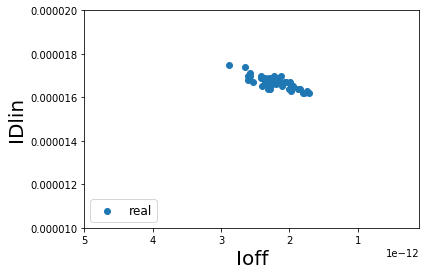

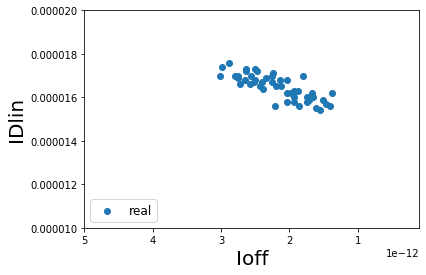

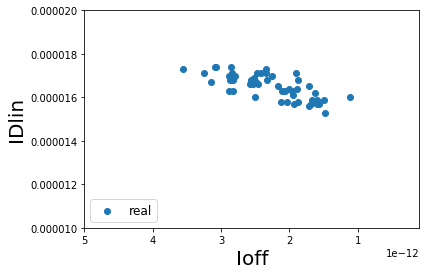

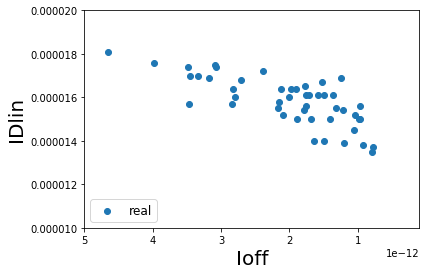

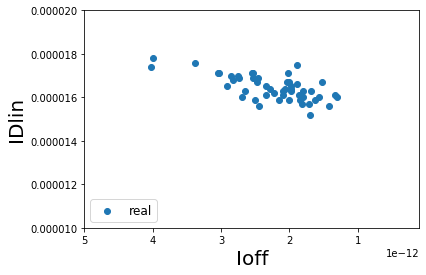

In [3]:
# TEST SET Visualize


import pandas as pd
import numpy as np

############################################## CHANGE HERE ######################################################

# factor : test set index ( hard ones: 2 3 7 12 14 )
factor_list = [2, 3, 7, 12, 14]

#################################################################################################################

for i in range(len(factor_list)):
    start = num_in_cycle * factor_list[i]
    end = num_in_cycle * (factor_list[i]+1)

    plt.scatter(dataset.test_Y[start:end,0],dataset.test_Y[start:end,2], label='real')
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("Ioff", fontsize=20)
    plt.ylabel("IDlin", fontsize=20)
    plt.show()

# GENERATED DATA

#### required: generated sample in 'npy' file 
#### in ( test_num * sample_num, 6 ) shape 

In [5]:

############################################### CHANGE HERE ##################################################

# type your result name

total_name = 'total_date_20200927_data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50_pdrop_0.9.npy'

##############################################################################################################

total_result = np.load(total_name, allow_pickle=True)

sample_num = int(len(total_result)/test_num)
print("GENERATED SAMPLE shape: ",total_result.shape)
print("GENERATED SAMPLE NUM:", sample_num)

# checking nan value
print("any nan in real?: ", np.argwhere(np.isnan(real)))
print("any nan in generated?: ", np.argwhere(np.isnan(total_result)))



GENERATED SAMPLE shape:  (750, 6)
GENERATED SAMPLE NUM: 50
any nan in real?:  []
any nan in generated?:  []


# FID SCORE 

In [6]:
score, FID_score_list = sample_utils.FID_score_each_X((total_result-y_mean) / y_std, (real - y_mean) / y_std, num_in_gen=sample_num, num_in_cycle=num_in_cycle)
print('FID_score_mean', score)
for i in range(len(FID_score_list)):
    print("FID_score for each X factor {}: {}".format(i, FID_score_list[i]))

# A: Ioff, B: IDSat, C: IDlin, D: VTsat, E:VTlin, F:SS, G: classs


FID_score_mean 0.495415554700838
FID_score for each X factor 0: 0.06337694600874978
FID_score for each X factor 1: 0.7053024873996807
FID_score for each X factor 2: 0.03287915834269695
FID_score for each X factor 3: 0.1566603989353297
FID_score for each X factor 4: 0.04713788244827259
FID_score for each X factor 5: 0.15307055210453654
FID_score for each X factor 6: 1.0116484613141472
FID_score for each X factor 7: 0.2561243754413645
FID_score for each X factor 8: 1.0198510515479235
FID_score for each X factor 9: 0.4592369939471439
FID_score for each X factor 10: 1.1390136652203857
FID_score for each X factor 11: 0.9530819472630935
FID_score for each X factor 12: 1.1411357233135324
FID_score for each X factor 13: 0.08679834561250499
FID_score for each X factor 14: 0.2059153316132085


# FEATURE DISTRIBUTION



In [7]:
import pandas as pd
import numpy as np

############################################### CHANGE HERE ##################################################

# type the X index of test sample ( 0 ~ 14) ( hard ones: 2 3 7 12 14 )

factor = 2

##############################################################################################################
"""
for i in range(6):
    print(np.min(total_result[:,i]))
    print(np.max(total_result[:,i]))
    print(np.min(real[:,i]))
    print(np.max(real[:,i]))
"""

# generated sample
gan_matrix_plot = total_result[factor * sample_num:(factor+1)*sample_num]
print("Generated sample shape:", gan_matrix_plot.shape)

# real sample
real_matrix_plot = real[factor * num_in_cycle:(factor+1)*num_in_cycle]
print("real sample shape:", real_matrix_plot.shape)
print()

# Assigning class(generated: 0, real:1 ) for visualization

print("Assigning class for visualization (generated: 0, real:1 )")

gan_cls = np.zeros((sample_num, 1))
print("generated sample class shape:", gan_cls.shape)
real_cls = np.ones((50, 1))
print("real sample class shape:", real_cls.shape)

temp1 = np.hstack([gan_matrix_plot, gan_cls])
temp2 = np.hstack([real_matrix_plot, real_cls])

# TOTAL PANDAS DATA
total_matrix_plot = np.vstack([temp1, temp2])
# print(total_matrix_plot.shape)

# A: Ioff, B: IDSat, C: IDlin, D: VTsat, E:VTlin, F:SS, G: classes
df1 = pd.DataFrame(total_matrix_plot, columns=['Ioff', 'IDSat',  'IDlin',  'VTsat', 'VTlin', 'SS', 'classes'])
# print(df1)


Generated sample shape: (50, 6)
real sample shape: (50, 6)

Assigning class for visualization (generated: 0, real:1 )
generated sample class shape: (50, 1)
real sample class shape: (50, 1)


minimum y value for each varaible: [1.64876972e-12 4.15759159e-05 1.60861477e-05 3.36000000e-01
 3.44182953e-01 6.14044697e+01 0.00000000e+00]
maximum y value for each varaible: [2.88000000e-12 4.43982946e-05 1.75000000e-05 3.47876559e-01
 3.54415889e-01 6.19320000e+01 1.00000000e+00]
X input [  0.163  61.383 147.843   1.      0.   ]


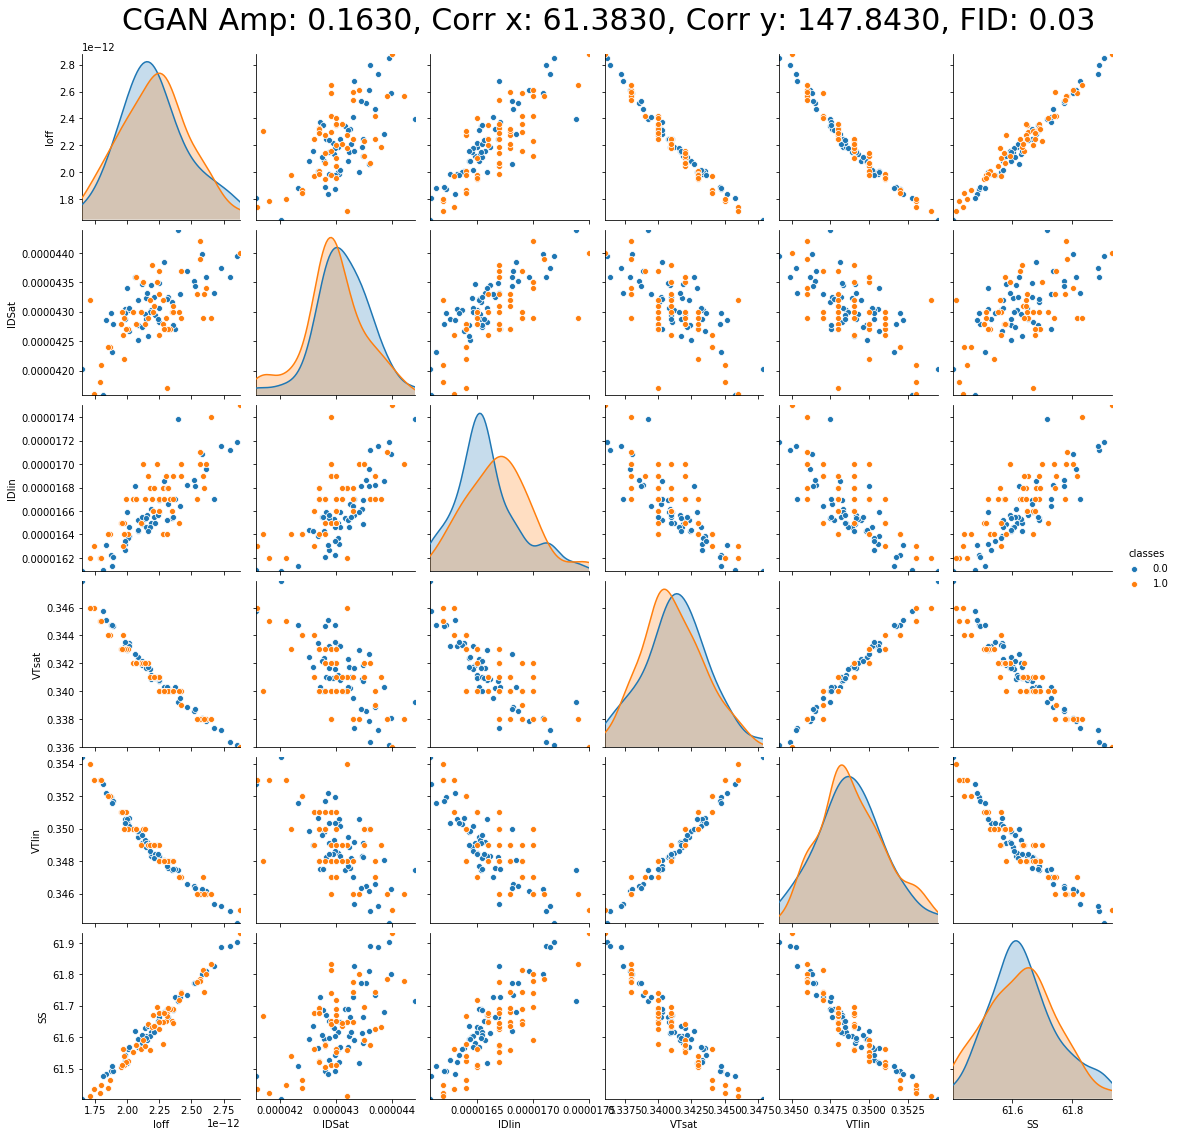

In [8]:
import seaborn as sns

# min, max for generated Y value ( used for scatter plot limit standard )

min_list = total_matrix_plot.min(axis=0)
max_list = total_matrix_plot.max(axis=0)
print("minimum y value for each varaible:", min_list)
print("maximum y value for each varaible:", max_list)

X = dataset.test_X_per_cycle[factor]

print("X input", X)

g = sns.pairplot(df1, hue = 'classes')
for i in range(6):
    g.fig.suptitle("CGAN Amp: {:.4f}, Corr x: {:.4f}, Corr y: {:.4f}, FID: {:.2f}".format(X[0], X[1], X[2], FID_score_list[factor]), y=1.04, fontsize=30)
    g.axes[i,i].set_xlim((min_list[i],max_list[i]))
    g.axes[i,i].set_ylim((min_list[i],max_list[i]))
plt.show()

# SCATTER PLOT two variable

check sample_num:  50


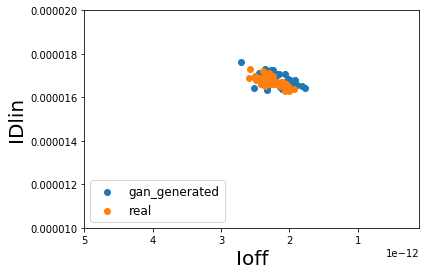

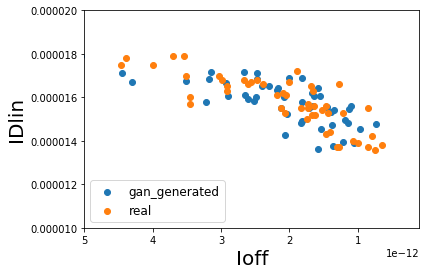

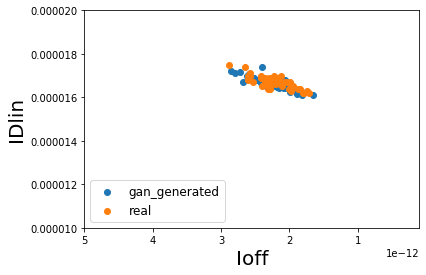

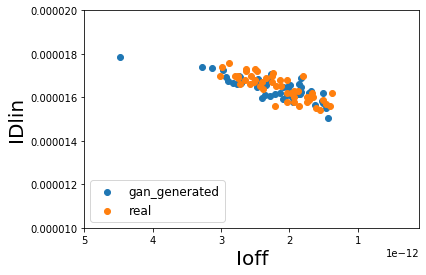

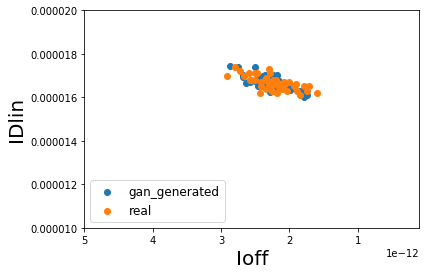

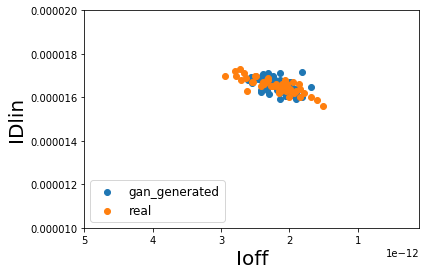

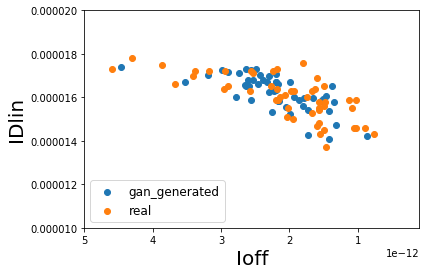

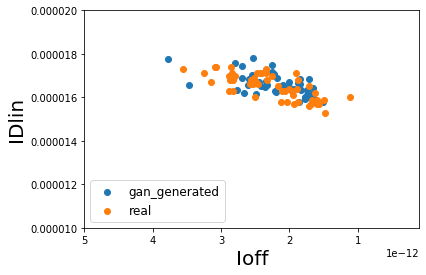

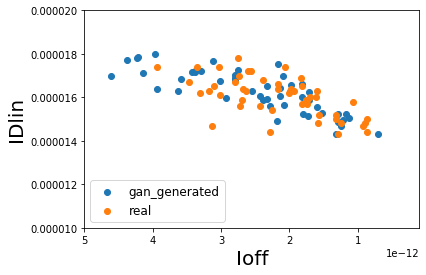

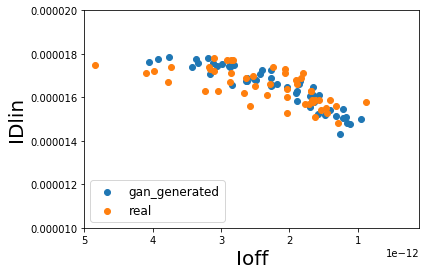

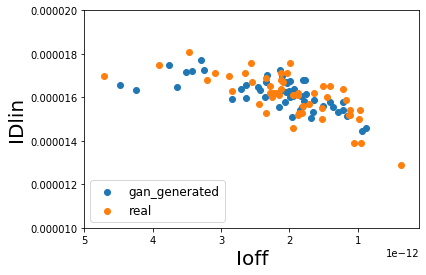

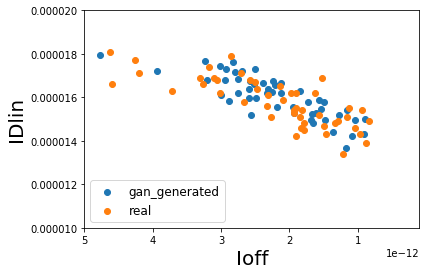

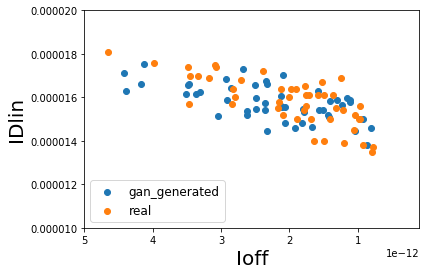

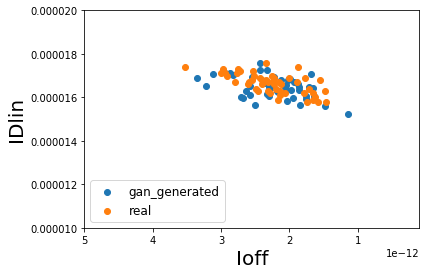

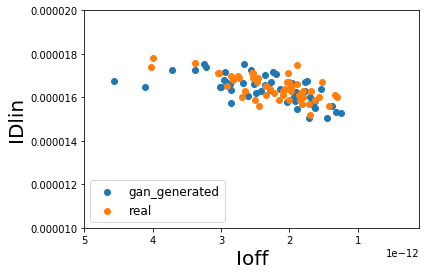

In [9]:
# ( Ioff / IDlin )

print("check sample_num: ", sample_num)

factor_plot = sample_num // num_in_cycle
for idx in range(15):
    start = num_in_cycle * idx
    end = num_in_cycle * (idx+1)
    plt.scatter(total_result[start*factor_plot:end*factor_plot,0],total_result[start*factor_plot:end*factor_plot,2], label='gan_generated')
    plt.scatter(real[start:end,0],real[start:end,2], label='real')
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("Ioff", fontsize=20)
    plt.ylabel("IDlin", fontsize=20)
    plt.show()

check sample_num:  50


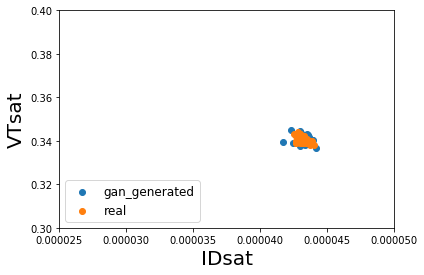

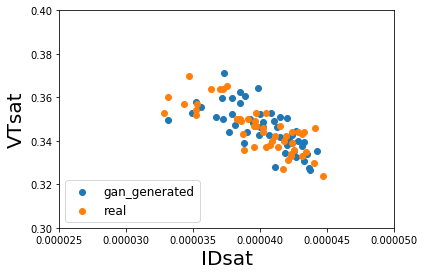

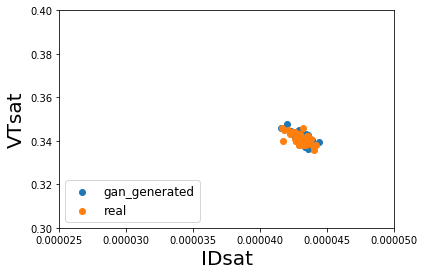

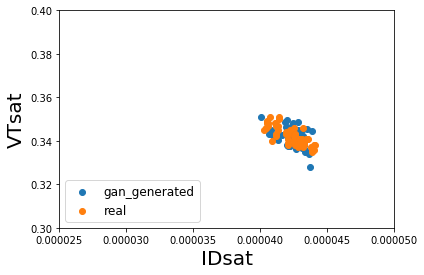

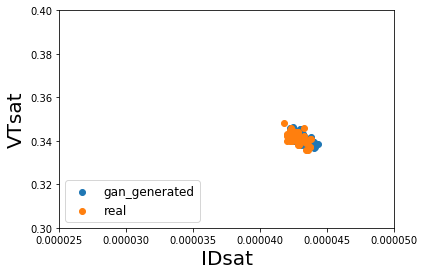

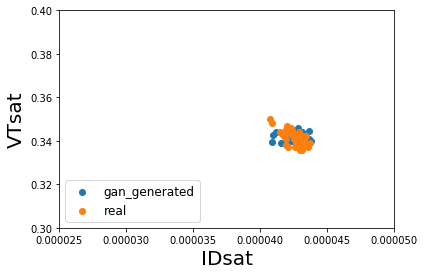

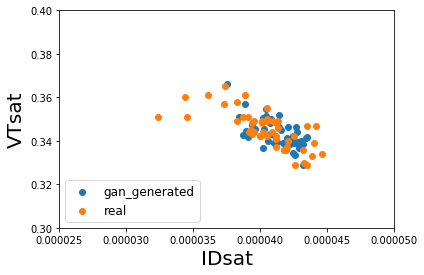

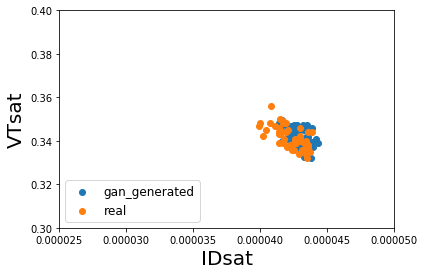

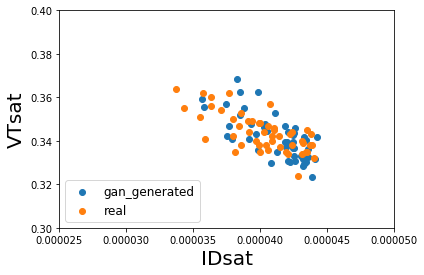

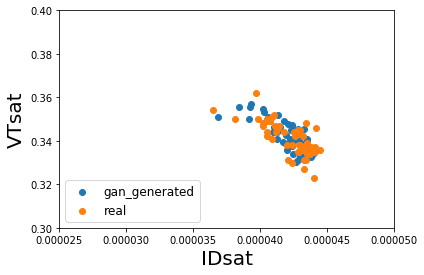

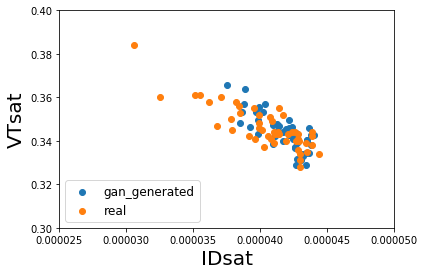

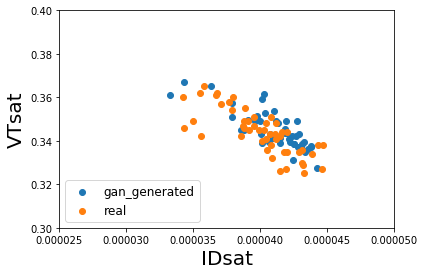

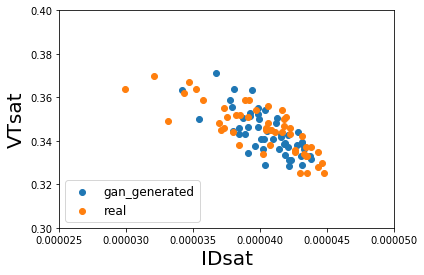

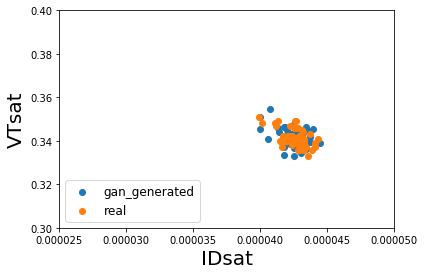

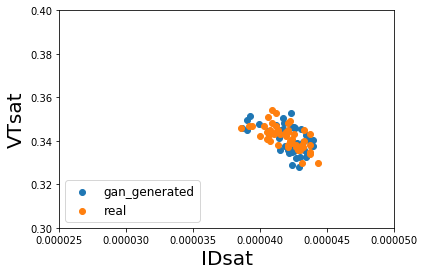

In [10]:
# ( IDsat / VTsat )

print("check sample_num: ", sample_num)

factor = sample_num // num_in_cycle
for idx in range(15):
    start = num_in_cycle * idx
    end = num_in_cycle * (idx+1)
    plt.scatter(total_result[start*factor_plot:end*factor_plot,1],total_result[start*factor_plot:end*factor_plot,3], label='gan_generated')
    plt.scatter(real[start:end,1],real[start:end,3], label='real')
    plt.xlim(2.5e-5, 5e-5)
    plt.ylim(3e-1, 4e-1)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("IDsat", fontsize=20)
    plt.ylabel("VTsat", fontsize=20)
    plt.show()